# Covid19 USA States

In [1]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

Starting qgis application

In [2]:
QgsApplication.setPrefixPath(r'C:\\OSGeo4W64\\apps\\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W64\apps\qgis\python\plugins')

In [3]:
project = QgsProject.instance()

Load shapefile of USA States

In [4]:
# load map layer
usa_path = "data/usa_states_map/tl_2017_us_state.shp"
usa_layer = QgsVectorLayer(usa_path, 'USA States Map', 'ogr')

if not usa_layer.isValid():
    print("Failed to load the layer!")
else:
    project.addMapLayer(usa_layer)

Load csv file of covid19 data and create a vector layer

In [5]:
dates = ['04-13-2020', '04-20-2020', '04-27-2020']

def loadCSVVectorLayer(date):
    # load covid-19 numbers 04-13-2020
    covid_path = "file:///E:/TA-Cartografia/data/covid19-usa/{}.csv".format(date)
    layer_name = 'covid{}'.format(date)
    covid_layer = QgsVectorLayer(covid_path, layer_name, 'delimitedtext')

    if not covid_layer.isValid():
        print('Layer failed to load!')
    else:
        project.addMapLayer(covid_layer)
        
for date in dates:
    loadCSVVectorLayer(date)

Join covid layers to usa layer

In [6]:
targetField = 'NAME'
joinField = 'Province_State'

In [7]:
def joinCSVSHPVectorLayers(csv_layer):
    joinObject = QgsVectorLayerJoinInfo()
    joinObject.setJoinFieldName(joinField)
    joinObject.setTargetFieldName(targetField)
    joinObject.setJoinLayerId(csv_layer.id())
    joinObject.setUsingMemoryCache(True)
    joinObject.setJoinLayer(csv_layer)
    flag = usa_layer.addJoin(joinObject)
    return flag
    
for date in dates:
    layer_name = 'covid{}'.format(date)
    csv_layer = project.mapLayersByName(layer_name)[0]
    flag = joinCSVSHPVectorLayers(csv_layer)

Add new field to the vector layer

In [8]:
caps = usa_layer.dataProvider().capabilities()

if caps & QgsVectorDataProvider.AddAttributes:
    new_fields = [
        QgsField("d13_20", QVariant.Int),
        QgsField("d20_27", QVariant.Int),
        QgsField("delta", QVariant.Int)
    ]
    res = usa_layer.dataProvider().addAttributes(new_fields)
usa_layer.updateFields()

Remove features without confirmed cases

In [9]:
del_ids = []

def removeFeature(conf1, conf2, conf3):
    flag1 = conf1 is None or conf1 == 0
    flag2 = conf2 is None or conf2 == 0
    flag3 = conf3 is None or conf3 == 0
    return flag1 or flag2 or flag3

if caps & QgsVectorDataProvider.DeleteFeatures:
    for feature in usa_layer.getFeatures():
        conf1 = feature['covid04-27-2020_Confirmed']
        conf2 = feature['covid04-20-2020_Confirmed']
        conf3 = feature['covid04-13-2020_Confirmed']
        if removeFeature(conf1, conf2, conf3):
            del_ids.append(feature.id())
    res = usa_layer.dataProvider().deleteFeatures(del_ids)

Update delta fields of each feature

In [10]:
updateFeat = {}
fid1 = usa_layer.fields().indexFromName('d13_20')
fid2 = usa_layer.fields().indexFromName('d20_27')
fid3 = usa_layer.fields().indexFromName('delta')

for feature in usa_layer.getFeatures():
    conf13 = feature['covid04-13-2020_Confirmed']
    conf20 = feature['covid04-20-2020_Confirmed']
    conf27 = feature['covid04-27-2020_Confirmed']
    attrs = {}
    attrs[fid1] = conf20 - conf13
    attrs[fid2] = conf27 - conf20
    attrs[fid3] = attrs[fid2] - attrs[fid1]
    updateFeat[feature.id()] = attrs
usa_layer.dataProvider().changeAttributeValues(updateFeat)

True

Display graph of the number of infected

In [12]:
import numpy as np
import matplotlib.pyplot as plt

Retrieving the data

In [13]:
# data
states_list = ['California', 'Colorado', 'Minnesota', 'New Jersey', 'New York', 'Texas']
delta1 = []
delta2 = []
states = []

for feature in usa_layer.getFeatures():
    if feature['NAME'] in states_list:
        states.append(feature['NAME'])
        delta1.append(feature['d13_20'])
        delta2.append(feature['d20_27'])

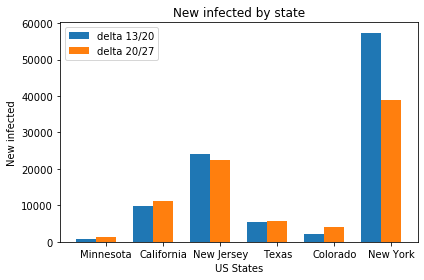

In [14]:
# create plot
fig, ax = plt.subplots()
index = np.arange(len(delta1))
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='delta 13/20')

rects2 = plt.bar(index + bar_width, delta2, bar_width, label='delta 20/27')

plt.xlabel('US States')
plt.ylabel('New infected')
plt.title('New infected by state')
plt.xticks(index + bar_width, tuple(states))
plt.legend()

plt.tight_layout()
plt.show()

Image of the evolution of new infected

In [15]:
target_field = 'delta'
myRangeList = []

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())     
symbol.setColor(QColor(22, 22, 222))                              
myRange = QgsRendererRange(-11111111, 0, symbol, 'New infecteds are lower')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(222, 22, 2))
myRange = QgsRendererRange(1, 5000000, symbol, 'New infecteds are higher')
myRangeList.append(myRange)

myRenderer = QgsGraduatedSymbolRenderer(target_field, myRangeList)
myRenderer.setMode(QgsGraduatedSymbolRenderer.Custom)               

usa_layer.setRenderer(myRenderer)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated
  from ipykernel import kernelapp as app


In [16]:
xt = usa_layer.extent()
# print(xt)
width  = 1000
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([usa_layer])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 1000 por 162


In [17]:
from IPython.display import Image

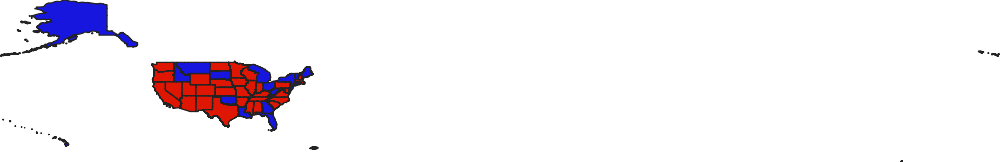

In [18]:
imgbuf = QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

In [19]:
qgs.exitQgis()